In [1]:
import pandas as pd
import numpy as np

#Visualisation
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone

#Features selection
from sklearn.feature_selection import VarianceThreshold

#Modelisation
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,learning_curve,RepeatedStratifiedKFold,cross_val_predict,cross_val_score
from sklearn.linear_model import LogisticRegression

#Performances
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve,f1_score,log_loss

In [2]:
#Display matrice de confusion
def plot_confusion_matrix(cm:np.array,classes:tuple,
                          normalize:bool = False,title:str ='Matrice de Confusion',
                          cmap = plt.cm.YlGn):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classes réelles')
    plt.xlabel('Classes prédites')
    plt.tight_layout()
    
#Correlation matrix
def corr_matrix(df: pd.DataFrame,annotate=False):
    plt.figure(figsize=(15,10))
    sns.heatmap(df.corr(),
                cmap=plt.cm.RdBu,
                vmax=1.0,
                linewidths=0.1,
                linecolor='white',
                square=True,
                annot=annotate
                )
    
#Fonction permet d'afficher les courbes ROCS des deux classes à prédire
def plot_roc_curve(y_true: pd.Series,
             y_proba: pd.Series,
             y_pred: pd.Series) :
    col = ['r','b'] #Couleur des courbes
    labels = ['No Churn','Churn']
    roc_auc = roc_auc_score(y_true, y_pred)
    for i in range(len(col)):
        fpr, tpr, thr = roc_curve(y_true, y_proba[:,i], pos_label=i) #Calcul de la courbe ROC des trois classes
        plt.plot(fpr, tpr,'-',c=col[i], label=labels[i]) #Affichage des courbes avec la couleur correspondante et la classe
    plt.plot([0,1],[0,1],'k--', label='hasard') #Courbe ROC par défaut
    plt.plot(label=f"Model (area = {round(roc_auc,2)}")
    plt.xlabel(f"FPR Specificty")
    plt.ylabel(f"TPR (Sensitivity)")
    plt.legend(loc=4)
    plt.show()
    
def save_scores(scores:dict,
                model_name:str,
                verbose:bool=True)->pd.DataFrame:
    
    if verbose:
        print(f"Scores training f1 weighted : {round(scores['train_f1_weighted'].mean(),3)} (+/- {round(scores['train_f1_weighted'].std(),3)})")
        print(f"Scores test f1 weighted : {round(scores['test_f1_weighted'].mean(),3)} (+/- {round(scores['test_f1_weighted'].std(),3)})")
    
        print(f"Scores training accuracy : {round(scores['train_accuracy'].mean(),3)} (+/- {round(scores['train_accuracy'].std(),3)})")
        print(f"Scores test accuracy : {round(scores['test_accuracy'].mean(),3)} (+/- {round(scores['test_accuracy'].std(),3)})")
    
        print(f"Scores training roc_auc : {round(scores['train_roc_auc'].mean(),3)} (+/- {round(scores['train_roc_auc'].std(),3)})")
        print(f"Scores test roc_auc : {round(scores['test_roc_auc'].mean(),3)} (+/- {round(scores['test_roc_auc'].std(),3)})")
    
        print(f"Scores training precision : {round(scores['train_precision'].mean(),3)} (+/- {round(scores['train_precision'].std(),3)})")
        print(f"Scores test precision : {round(scores['test_precision'].mean(),3)} (+/- {round(scores['test_precision'].std(),3)})")
    
        print(f"Scores training recall : {round(scores['train_recall'].mean(),3)} (+/- {round(scores['train_recall'].std(),3)})")
        print(f"Scores test recall : {round(scores['test_recall'].mean(),3)} (+/- {round(scores['test_recall'].std(),3)})")
    
    return pd.DataFrame({'test_f1_weighted':round(scores['test_f1_weighted'].mean(),2),
                       'test_f1_weighted_std':round(scores['test_f1_weighted'].std(),3),
                       'test_roc_auc':round(scores['test_roc_auc'].mean(),2),
                       'test_roc_auc_std':round(scores['test_roc_auc'].std(),3),
                       'test_precision':round(scores['test_precision'].mean(),2),
                       'test_precision_std':round(scores['test_precision'].std(),3),
                       'test_recall':round(scores['test_recall'].mean(),2),
                       'test_recall_std':round(scores['test_recall'].std(),3),
                       'test_accuracy':round(scores['test_accuracy'].mean(),2),
                       'test_accuracy_std':round(scores['test_accuracy'].std(),3),
                        'Model_name':pd.Series(model_name)})

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),minus=True):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes,
                            train_scores_mean + train_scores_std,
                            train_scores_mean - train_scores_std,alpha=0.1,
                            color="r")
    axes[0].fill_between(train_sizes,test_scores_mean + test_scores_std,
                         test_scores_mean - test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
        
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    # Plot learning curve cost
    axes[1].set_title(title+' cost')
    axes[1].grid()
    axes[1].fill_between(train_sizes,
                         1 - train_scores_mean + train_scores_std,
                         1 - train_scores_mean - train_scores_std,alpha=0.1,
                         color="r")
    axes[1].fill_between(train_sizes, 1 - test_scores_mean + test_scores_std,
                         1 - test_scores_mean - test_scores_std, alpha=0.1,
                         color="g")
    axes[1].plot(train_sizes, 1 - train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[1].plot(train_sizes, 1 - test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[1].legend(loc="best")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Cost = 1 - Score")
    #plt.show()
        
    df = pd.DataFrame({'train_sizes':train_sizes,
                        'train_score':train_scores_mean,
                        'train_std':train_scores_std,
                        'test_score':test_scores_mean,
                        'test_std':test_scores_std,
                        'train_size_per':np.round(train_sizes/X.shape[0],2)})
    
    return plt,df

def cross_val_monitor(model_tuple:tuple,
                      X: pd.DataFrame,
                      y: pd.Series):
    model_name,model = model_tuple
    print(f"Compute the cross validation on : {X.shape[0]} data split on 5 folds with {model_name} estimator")
    scores = cross_validate(model,X,y,
                            cv=skfolds.split(X,y),
                            scoring=['f1_weighted','roc_auc','accuracy','precision','recall'],
                            return_train_score=True,
                            verbose=0)
    print(f"\n Display score: {model_name}")
    scoring = save_scores(scores,model_name)
    title = f"Learning Curves: {model_name}"
    plot_learning_curve(model, title, X, y,
                        cv=skfolds.split(X,y), n_jobs=4)
    plt.show()
    
    print("Evaluating all dataset with cross val predict")
    print("Warning : Cross_val_predict is not an appropriate measure of generalisation error, I use it just for have an idea of the confusion matrix")
    model_pred = cross_val_predict(model,X,y)
    conf = confusion_matrix(y,model_pred)
    plot_confusion_matrix(conf,classes=['No Churn','Churn'])
    print('\n\n\n')
    
    return scoring

#Fonction qui permet d'afficher les courbes ROC's, matrice de confusion et différents scores
#en fonction des différents modèle
def compute_metrics(x, y_true, clf) :
    y_pred = clf.predict(x)
    conf = confusion_matrix(y_true, y_pred)
    try:
        y_proba = clf.predict_proba(x)
        plot_roc_curve(y_pred=y_pred,y_proba=y_proba,y_true=y_true)
    except:
        print(f"L'estimator n'a pas de probabilités\n")
        
    print ("Matrice de confusion :\n")
    plot_confusion_matrix(conf,classes=['No Churn','Churn'])
    plt.show()
    
    print ("Resultats :\n")
    print (classification_report(y_true, y_pred))
    
    return f1_score(y_true, y_pred, average='weighted') #Retourne le f1-score car la méthode au meilleure f1-score sera choisie


#Fonction qui permet d'éxécuter une liste de classifieurs et d'en ressortir des mesures de performances
def compute_performances(lstClf,
                X_train,y_train,X_test,y_test):
    f1_score_lst = list()
    model_name_list =list()
    score_lst = list()
    for model_name, clf in lstClf:
        clf.fit(X_train,y_train)
        print("\n" + model_name)
        f1_score_lst.append([model_name, compute_metrics(X_test, y_test, clf)])
    for name,score in f1_score_lst:
        model_name_list.append(name)
        score_lst.append(score)
    best_f1_score = max(score_lst)
    ind_best_f1_score = score_lst.index(best_f1_score)
    best_model = model_name_list[ind_best_f1_score]
    
    return (f"le meilleure modèle est : {best_model} avec un f1-score de : {best_f1_score}")

def plot_performances(df,col,metric_name,color):
    bar_plot = go.Bar(y = df[col],
                      x = df[metric_name],
                      orientation = "h",
                      name = metric_name.replace('test_',''),
                      marker = dict(line = dict(width =.7),
                                    color = color)
                     )
    return bar_plot

def construct_df_pred(lstClf,X_train,y_train,X_test):
    pred_df = pd.DataFrame()
    for model_name,model in lstClf:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        pred_df[model_name] = y_pred
    return pred_df

def construct_corr_matrix(prediction_df,colormap=plt.cm.Blues,title='Correlations des prédictions'):
    corr_pred = pd.DataFrame(index=prediction_df.columns, columns=prediction_df.columns).fillna(0)
    for i in range(0, len(corr_pred)):
        for j in range(0, i+1):
            corr_pred.iloc[i,j]= ((prediction_df.iloc[:,i] - prediction_df.iloc[:,j]).value_counts()[0])/len(prediction_df)*100
    mask = np.triu(np.ones_like(corr_pred, dtype=np.bool))
    plt.figure(figsize=(15,9))
    plt.title(title,fontweight="bold")
    sns.heatmap(corr_pred ,linewidths=0.1, vmax=100, vmin=0, mask=mask,
                square=True, cmap=colormap, linecolor='white', annot=True)

def distribution_class(prediction_df,colormap=plt.cm.Blues,title='Distribution des predictions en fonction des classes'):
    level = pd.DataFrame(index=prediction_df.columns, columns=range(0,2)).fillna(0)
    for i in level.index:
        for j in level.columns:
            level.loc[i,j]= prediction_df[i].value_counts()[j]/len(prediction_df)*100
    plt.figure(figsize=(15,9))
    plt.title(title,y=1.05,fontweight="bold")
    sns.heatmap(level ,linewidths=0.1, vmax=100, vmin=0,
                square=True, cmap=colormap, linecolor='white', annot=True)

In [3]:
#Settings display pandas
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
#Read pre-processing data
data_prepro = pd.read_csv('Data/churn_prepro.csv')

In [5]:
data_prepro.head()

customerID  gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  PaperlessBilling  MonthlyCharges  TotalCharges  Churn_bool  InternetService_DSL  InternetService_Fiber optic  InternetService_No  Contract_Month-to-month  Contract_One year  Contract_Two year  PaymentMethod_Bank transfer (automatic)  PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  PaymentMethod_Mailed check  tenure_cut_Low  tenure_cut_Mid  tenure_cut_High  MonthlyCharges_cut_Low  MonthlyCharges_cut_Mid  MonthlyCharges_cut_High  TotalCharges_cut_Low  TotalCharges_cut_Mid  TotalCharges_cut_High
0  7590-VHVEG       0              0        1           0 -1.277445             0              0               0             1                 0            0            0                0                 1       -1.160323     -0.994242           0                    1                            0                   0                        1                  0                  0                                        0                                      0                               1                           0               1               0                0                       1                       0                        0                     1                     0                      0
1  5575-GNVDE       1              0        0           0  0.066327             1              0               1             0                 1            0            0                0                 0       -0.259629     -0.173244           0                    1                            0                   0                        0                  1                  0                                        0                                      0                               0                           1               0               1                0                       0                       1                        0                     0                     1                      0
2  3668-QPYBK       1              0        0           0 -1.236724             1              0               1             1                 0            0            0                0                 1       -0.362660     -0.959674           1                    1                            0                   0                        1                  0                  0                                        0                                      0                               0                           1               1               0                0                       0                       1                        0                     1                     0                      0
3  7795-CFOCW       1              0        0           0  0.514251             0              0               1             0                 1            1            0                0                 0       -0.746535     -0.194766           0                    1                            0                   0                        0                  1                  0                                        1                                      0                               0                           0               0               1                0                       1                       0                        0                     0                     1                      0
4  9237-HQITU       0              0        0           0 -1.236724             1              0               0             0                 0            0            0                0                 1        0.197365     -0.940470           1                    0                            1                   0                        1                  0                  0                                        0                                

In [6]:
#Possibility of delete the continuos features or the categoricals
data_prepro.drop(['tenure','MonthlyCharges','TotalCharges'],axis=1,inplace=True)

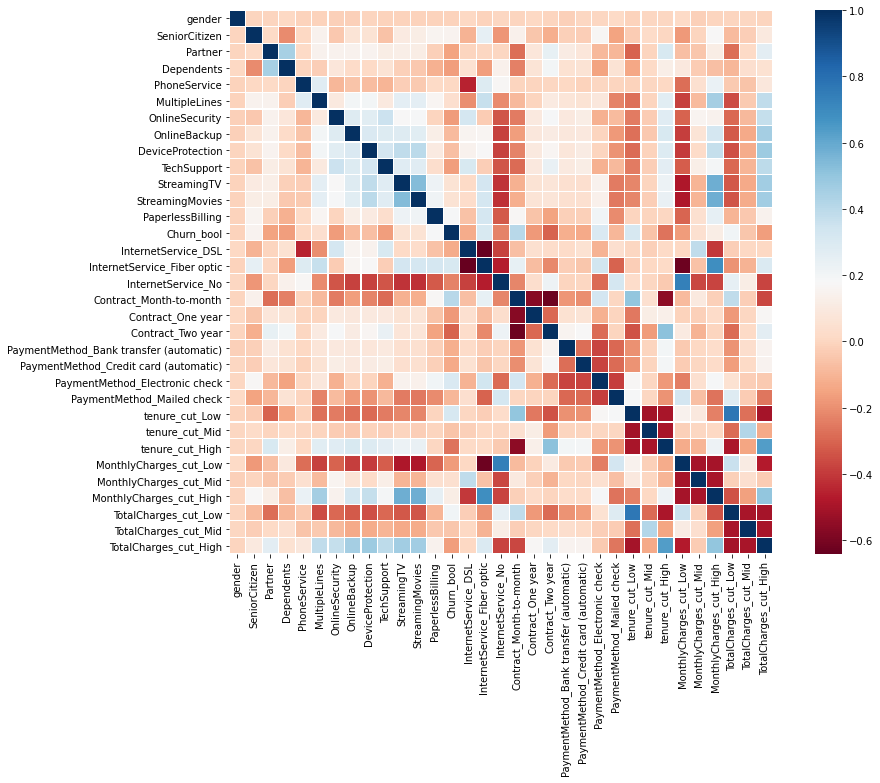

In [7]:
corr_matrix(data_prepro)

In [8]:
customersID = data_prepro.customerID.copy()
X = data_prepro.drop(['Churn_bool','customerID'],axis=1)
y = data_prepro.Churn_bool.copy()

In [9]:
X.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  PaperlessBilling  InternetService_DSL  InternetService_Fiber optic  InternetService_No  Contract_Month-to-month  Contract_One year  Contract_Two year  PaymentMethod_Bank transfer (automatic)  PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  PaymentMethod_Mailed check  tenure_cut_Low  tenure_cut_Mid  tenure_cut_High  MonthlyCharges_cut_Low  MonthlyCharges_cut_Mid  MonthlyCharges_cut_High  TotalCharges_cut_Low  TotalCharges_cut_Mid  TotalCharges_cut_High
0       0              0        1           0             0              0               0             1                 0            0            0                0                 1                    1                            0                   0                        1                  0                  0                                        0                                      0                               1                           0               1               0                0                       1                       0                        0                     1                     0                      0
1       1              0        0           0             1              0               1             0                 1            0            0                0                 0                    1                            0                   0                        0                  1                  0                                        0                                      0                               0                           1               0               1                0                       0                       1                        0                     0                     1                      0
2       1              0        0           0             1              0               1             1                 0            0            0                0                 1                    1                            0                   0                        1                  0                  0                                        0                                      0                               0                           1               1               0                0                       0                       1                        0                     1                     0                      0
3       1              0        0           0             0              0               1             0                 1            1            0                0                 0                    1                            0                   0                        0                  1                  0                                        1                                      0                               0                           0               0               1                0                       1                       0                        0                     0                     1                      0
4       0              0        0           0             1              0               0             0                 0            0            0                0                 1                    0                            1                   0                        1                  0                  0                                        0                                      0                               1                           0               1               0                0                       0                       1                        0                     1                     0                      0

In [10]:
X.shape

(7043, 32)

In [11]:
#An easy method to have a first filter of selection features it's to remove
#0 variances variable. Theses columns doesn't bring information for our model
selector = VarianceThreshold()
new_X = selector.fit_transform(X)
new_X = pd.DataFrame(new_X,columns=X.columns)

In [12]:
#It means that any columns contains the same values
new_X.shape

(7043, 32)

In [13]:
y.value_counts()/y.shape[0]

0    0.73463
1    0.26537
Name: Churn_bool, dtype: float64

In the beginning we choose a simple LogisticRegression Model.
In case of imbalanced data, we can adjust the class_weight hyperparameter with a custom weight (for example by taking the ratio of our classes) or pre-calculated weight.
- weight_churn = n_sample / (n_classe * n_sample_classe) = 7043/(2 * 1869) = 1.88
- weight_Nochurn = n_sample / (n_classe * n_sample_classe) = 7043/(2 * 5174) = 0.68

The weighting can penalize the model less for errors made on examples from the majority class and penalize the model more for errors made on examples from the minority class

#### Cross-Validated
Let's perform cross-validation !

In [14]:
#We define our strategy of cross validation 
#This strategy allow us split our dataset in 5 stratified susbsets then train and evaluate our model.
#So to have a train set with 80% of data and evaluate the model with 20% of data (5times with 5 differents subsets)
skfolds = StratifiedKFold(n_splits=5)

#### Logistic Regression

In [15]:
lr = LogisticRegression(max_iter=200,random_state=2)

The model does not perform that badly on training and validation test.<br/>
But the fact that we have approximativly the same score for each train and test metrics could means that our model have a high biais and converge at theses scores

When we look at the learning curve: 
- Training curve : We see she has a high biais (≈0.19) and has stable performance (not increase or decrease errors) from a training size which contains 80% of data.
- Validation curve : We see that the cost curve converge to the training curve at a high error score.

We can conclude that our model is underfitting but it's not a disaster !

The confusion matrix allow us to see more clearly what we can improve <br/>
In this kind of problematics, it's important to retain more customers because it's more cheaper than get new ones <br/>
So we have to increase the recall of churn customers so reduce the false negative <br/>
But do that can increase the false positive and decrease the precision of our predictive model (There is a tradeof to make between recall and precision)

Compute the cross validation on : 7043 data split on 5 folds with LR estimator

 Display score: LR
Scores training f1 weighted : 0.797 (+/- 0.004)
Scores test f1 weighted : 0.795 (+/- 0.007)
Scores training accuracy : 0.805 (+/- 0.003)
Scores test accuracy : 0.803 (+/- 0.007)
Scores training roc_auc : 0.846 (+/- 0.003)
Scores test roc_auc : 0.842 (+/- 0.012)
Scores training precision : 0.672 (+/- 0.007)
Scores test precision : 0.667 (+/- 0.02)
Scores training recall : 0.519 (+/- 0.01)
Scores test recall : 0.517 (+/- 0.014)


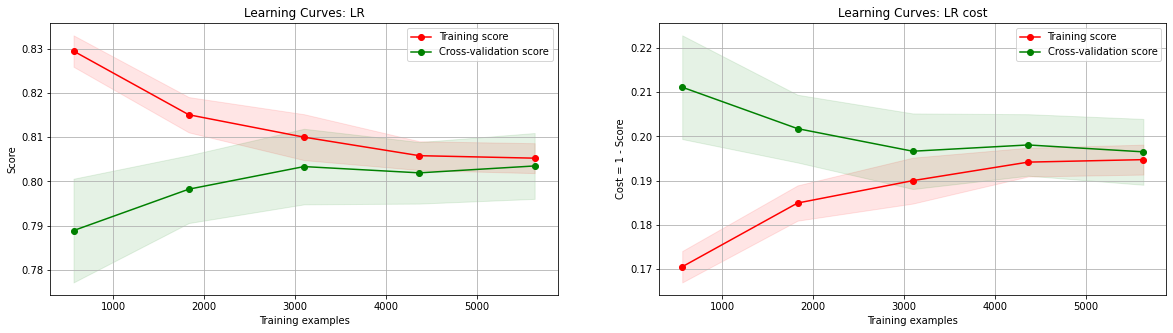

Evaluating all dataset with cross val predict






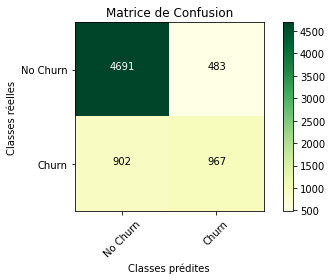

In [16]:
Lr_tuple = ("LR",lr)
lr_res = cross_val_monitor(Lr_tuple,X,y)

Let's build param grid and find the best params for our model </br>
We try to find the best params that optimize the f1-score weighted 

In [17]:
param_grid = {'C': [1.0,10.0,100.0,1000.0],
              'max_iter':[120,125,130,140,150],
              'class_weight': ['balanced',None]
             }
rg_cv = GridSearchCV(LogisticRegression(), param_grid, cv=skfolds.split(X,y), scoring='f1_weighted',verbose=0)
rg_cv.fit(X, y)
print(rg_cv.best_estimator_)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=120,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [18]:
rg_cv.best_score_

0.7953531461391311

Our assumption was corrects,we not increase the test score (Before grid search and after f1_weighted = 0.79)</br>
Adding more trainng data will not benefit to our model because the two curve score converge at 5 634 training sample</br>
The biais of the training curve is high ≈ 0.20. Our model is underfit but not highly 

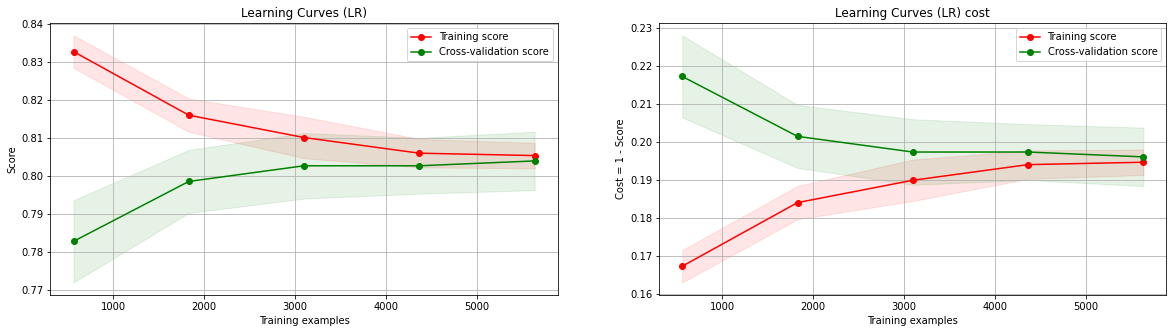

In [19]:
title = f"Learning Curves (LR)"
estimator = rg_cv.best_estimator_
_,score_learning = plot_learning_curve(estimator, title, X, y,
                    cv=skfolds.split(X,y), n_jobs=4)

plt.show()

In [20]:
#Score at each differents training size
#With 80% of training data we reach a score of 80% of good predictions (accuracy)

In [21]:
#Let's interpret the results
lr_coef = pd.DataFrame(np.concatenate([estimator.intercept_.reshape(-1,1),
                             estimator.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(X.columns)).T

Scikit learn doesn't provide so much output for the regression logistic,</br>
So the coef are not very useful because we don't know how each features are significantly for predict the customers churn</br>
We can just have some assumption that the features with positives coef tends to push our model to predict churn people</br>
Somes alternative are to use the logit function of the package stats.models that provide more outputs or lime,shape,eli5 package(maybe i'll use it in this script)</br>

In [22]:
lr_coef.sort_values(by='coef',ascending=False)

coef
InternetService_Fiber optic              1.043395
Contract_Month-to-month                  0.864841
tenure_cut_Low                           0.551151
TotalCharges_cut_Low                     0.401400
StreamingMovies                          0.327195
PaperlessBilling                         0.324478
StreamingTV                              0.322025
MultipleLines                            0.314914
PaymentMethod_Electronic check           0.258445
SeniorCitizen                            0.215070
MonthlyCharges_cut_Low                   0.175976
Contract_One year                        0.058601
DeviceProtection                         0.014154
InternetService_DSL                     -0.011322
gender                                  -0.021950
Partner                                 -0.040159
PaymentMethod_Bank transfer (automatic) -0.056964
PaymentMethod_Mailed check              -0.059604
MonthlyCharges_cut_Mid                  -0.064669
TotalCharges_cut_Mid                    -0.066974
MonthlyCharges_cut_High                 -0.111352
tenure_cut_Mid                          -0.129217
Dependents                              -0.132031
PaymentMethod_Credit card (automatic)   -0.141921
OnlineBackup                            -0.150469
TechSupport                             -0.290383
PhoneService                            -0.293359
TotalCharges_cut_High                   -0.334469
OnlineSecurity                          -0.338648
tenure_cut_High                         -0.421978
Contract_Two year                       -0.923485
InternetService_No                      -1.032117
constante                               -2.205231

For fix underfit problem we have a few possibilities :
- Choice more complex model (a boosting model could be a good due to the fact theirs goals is to reduce the biais of prediction by iterations)
- decrease regularization (example : here we don't penalize the minority class by set a dict values for the hyparameter class_weight, and we increase the C value)
- Add more features, transform polynomial features
- Better Feature engineering 

#### Decision Tree

In [23]:
#We choose to test a more complex model
from sklearn import tree

Here our model clearly overfitting : </br>
- Our model perform very well on the training set but perform poorly on the test set
- Training curve : The curve has a very low biais so our model perfom very well ! ... but too much that he'll cannot generalize new data
- Validation curve : The biais is high and the gap (high variance) between the two curves are important 

Compute the cross validation on : 7043 data split on 5 folds with DT estimator

 Display score: DT
Scores training f1 weighted : 0.948 (+/- 0.002)
Scores test f1 weighted : 0.729 (+/- 0.008)
Scores training accuracy : 0.949 (+/- 0.002)
Scores test accuracy : 0.73 (+/- 0.009)
Scores training roc_auc : 0.992 (+/- 0.001)
Scores test roc_auc : 0.669 (+/- 0.009)
Scores training precision : 0.95 (+/- 0.004)
Scores test precision : 0.491 (+/- 0.017)
Scores training recall : 0.853 (+/- 0.006)
Scores test recall : 0.477 (+/- 0.01)


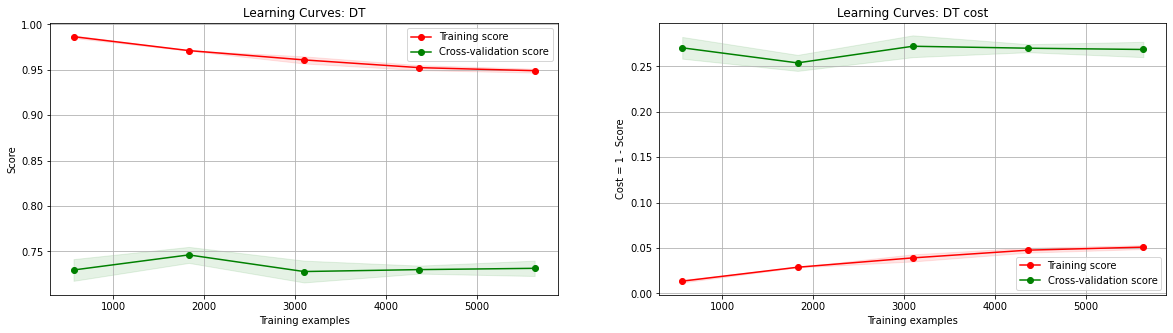

Evaluating all dataset with cross val predict






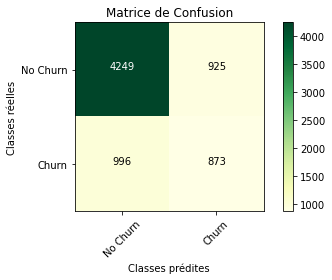

In [24]:
Dt_tuple = ("DT",tree.DecisionTreeClassifier())
Dt_res = cross_val_monitor(Dt_tuple,X,y)

For fix it we have solutions :
- Gave more training data (not easy solution in industry context)
- Regularize your model (constraint your model could reduce the variance but increase the biais this is the tradeof biais/variance)
- In our example we choose a tree model, to penalize our model we can increase the min_* and reduce the max_* hyparameters

In [25]:
#We try to find the best parameter that optimize our model and reduce the overfitting
#Generally i run the grid search function on a google colab notebook
params_grid = [{'max_depth': [9,10,11,15],
                'min_samples_split':[20,25,30,40,45],
                'class_weight':['balanced',None],
                'min_samples_leaf':[10,15,20,25,30],
                'criterion':['gini','entropy']}]
dt_gs = GridSearchCV(tree.DecisionTreeClassifier(), params_grid, cv=10, scoring='f1_weighted',verbose=0)
dt_gs.fit(X, y)
print(dt_gs.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [26]:
#Regularize with max_depth and class_weight
clf_tree_regul = ('Dt_regul',dt_gs.best_estimator_)

Compute the cross validation on : 7043 data split on 5 folds with Dt_regul estimator

 Display score: Dt_regul
Scores training f1 weighted : 0.798 (+/- 0.004)
Scores test f1 weighted : 0.784 (+/- 0.01)
Scores training accuracy : 0.809 (+/- 0.003)
Scores test accuracy : 0.796 (+/- 0.009)
Scores training roc_auc : 0.861 (+/- 0.002)
Scores test roc_auc : 0.824 (+/- 0.011)
Scores training precision : 0.691 (+/- 0.012)
Scores test precision : 0.657 (+/- 0.023)
Scores training recall : 0.506 (+/- 0.028)
Scores test recall : 0.479 (+/- 0.026)


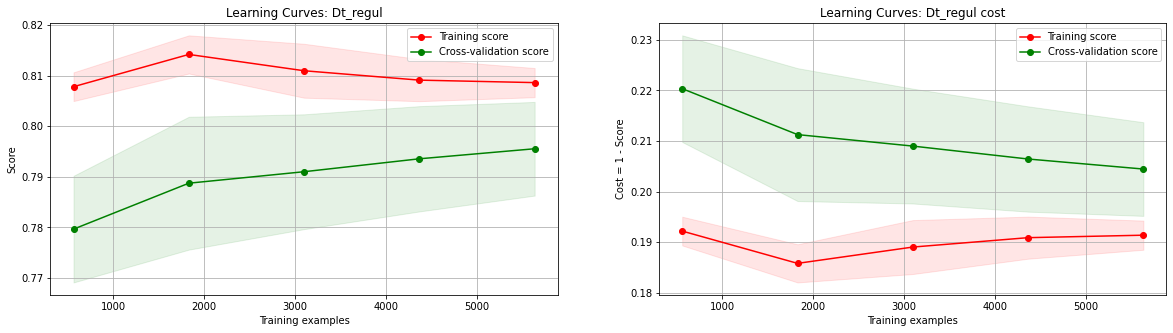

Evaluating all dataset with cross val predict






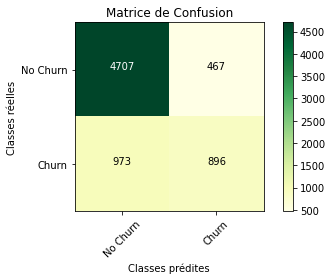

In [27]:
#Replace the results before because we don't need them
#After regularize, the model perform poorly and the validation results are not stable (high variance) still continue to overfit but less than without regularization
Dt_res = cross_val_monitor(clf_tree_regul,X,y)

Compute the cross validation on : 7043 data split on 5 folds with Knn estimator

 Display score: Knn
Scores training f1 weighted : 0.803 (+/- 0.003)
Scores test f1 weighted : 0.791 (+/- 0.013)
Scores training accuracy : 0.807 (+/- 0.003)
Scores test accuracy : 0.795 (+/- 0.013)
Scores training roc_auc : 0.855 (+/- 0.003)
Scores test roc_auc : 0.831 (+/- 0.015)
Scores training precision : 0.656 (+/- 0.009)
Scores test precision : 0.629 (+/- 0.027)
Scores training recall : 0.576 (+/- 0.01)
Scores test recall : 0.554 (+/- 0.033)


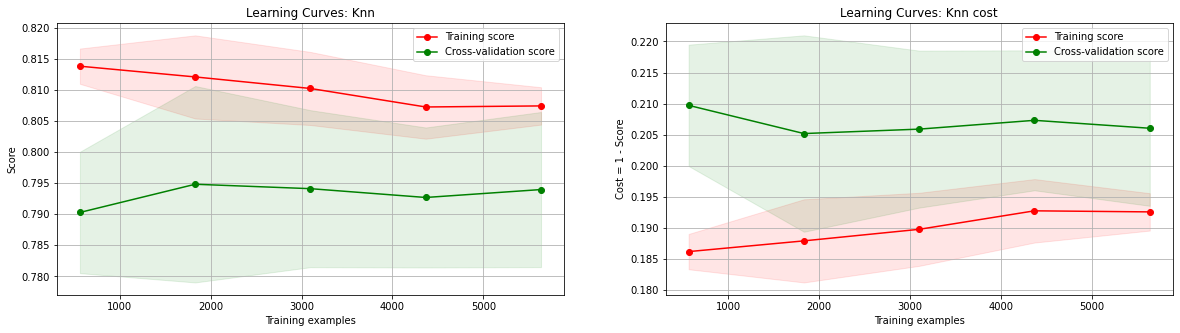

Evaluating all dataset with cross val predict






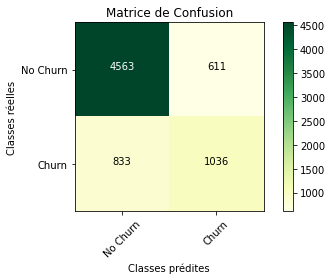

In [29]:
#Less are the neighbors more the model overfitting
from sklearn.neighbors import KNeighborsClassifier
clf_knn = ('Knn',KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                                      n_neighbors=29, p=1,weights='uniform'))
knn_res = cross_val_monitor(clf_knn,X,y)

Random forest is a model more robust and more accurate than decision tree so obvisouly we know that he'll overfit so i go to the next step

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
#Regularize decrease variance but could increase variance in the prediction scores 
#Wee see it with the validation curve
rf_regul = ('Rf',RandomForestClassifier(max_depth=6,max_features=30,min_samples_leaf=20, min_samples_split=30,
                            n_estimators=100,random_state=3))

Compute the cross validation on : 7043 data split on 5 folds with Rf estimator

 Display score: Rf
Scores training f1 weighted : 0.797 (+/- 0.003)
Scores test f1 weighted : 0.79 (+/- 0.012)
Scores training accuracy : 0.807 (+/- 0.003)
Scores test accuracy : 0.8 (+/- 0.011)
Scores training roc_auc : 0.861 (+/- 0.003)
Scores test roc_auc : 0.839 (+/- 0.011)
Scores training precision : 0.687 (+/- 0.007)
Scores test precision : 0.669 (+/- 0.028)
Scores training recall : 0.503 (+/- 0.009)
Scores test recall : 0.491 (+/- 0.024)


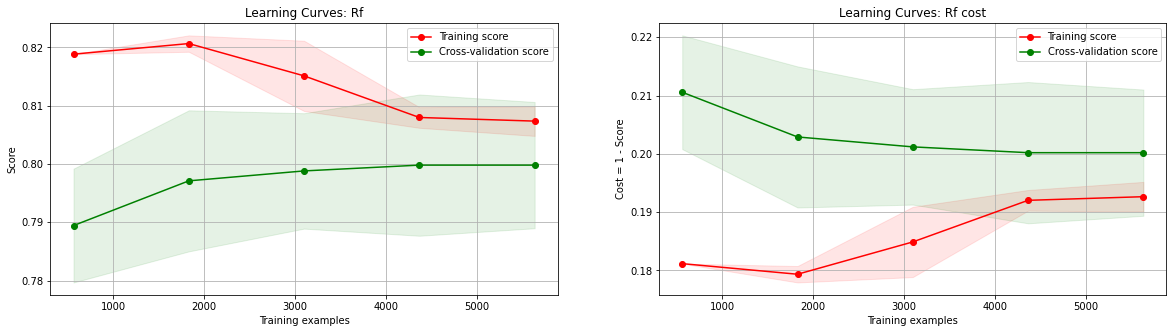

Evaluating all dataset with cross val predict






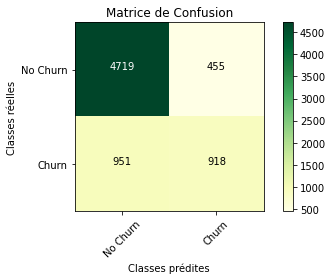

In [32]:
rf_res = cross_val_monitor(rf_regul,X,y)

In [33]:
#Here the model underfit at 80% of training data 
from sklearn.svm import SVC
clf_svc = ('SVC',SVC(C=100,gamma=0.0001, kernel='rbf',random_state=2, shrinking=True,
    tol=0.001))

Compute the cross validation on : 7043 data split on 5 folds with SVC estimator

 Display score: SVC
Scores training f1 weighted : 0.783 (+/- 0.005)
Scores test f1 weighted : 0.783 (+/- 0.01)
Scores training accuracy : 0.794 (+/- 0.005)
Scores test accuracy : 0.795 (+/- 0.009)
Scores training roc_auc : 0.833 (+/- 0.003)
Scores test roc_auc : 0.83 (+/- 0.009)
Scores training precision : 0.656 (+/- 0.022)
Scores test precision : 0.657 (+/- 0.028)
Scores training recall : 0.477 (+/- 0.022)
Scores test recall : 0.478 (+/- 0.041)


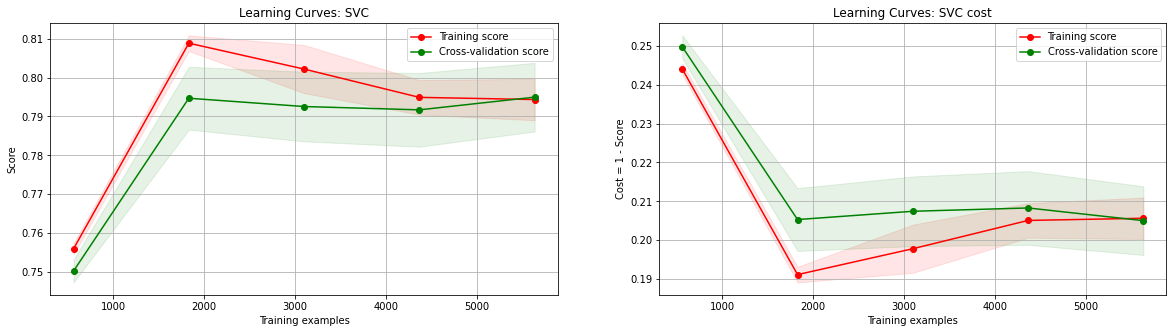

Evaluating all dataset with cross val predict






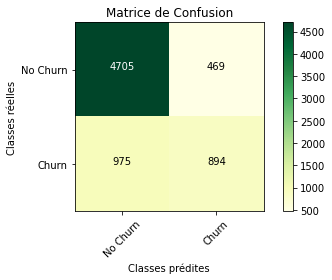

In [34]:
#Training curve score decrease 
svm_score = cross_val_monitor(clf_svc,X,y)

In [35]:
from sklearn.linear_model import SGDClassifier
clf_sgd = ('SGD',SGDClassifier(average=True,random_state=5))

Compute the cross validation on : 7043 data split on 5 folds with SGD estimator

 Display score: SGD
Scores training f1 weighted : 0.794 (+/- 0.004)
Scores test f1 weighted : 0.793 (+/- 0.007)
Scores training accuracy : 0.804 (+/- 0.003)
Scores test accuracy : 0.802 (+/- 0.006)
Scores training roc_auc : 0.845 (+/- 0.003)
Scores test roc_auc : 0.84 (+/- 0.011)
Scores training precision : 0.673 (+/- 0.008)
Scores test precision : 0.668 (+/- 0.016)
Scores training recall : 0.507 (+/- 0.009)
Scores test recall : 0.509 (+/- 0.015)


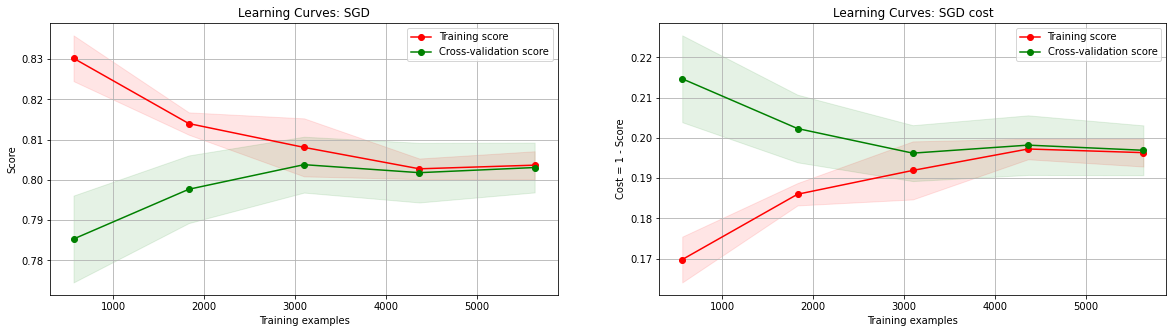

Evaluating all dataset with cross val predict






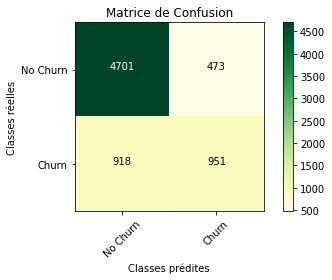

In [36]:
sgd_res = cross_val_monitor(clf_sgd,X,y)

Compute the cross validation on : 7043 data split on 5 folds with Gb estimator

 Display score: Gb
Scores training f1 weighted : 0.801 (+/- 0.003)
Scores test f1 weighted : 0.795 (+/- 0.01)
Scores training accuracy : 0.81 (+/- 0.003)
Scores test accuracy : 0.803 (+/- 0.009)
Scores training roc_auc : 0.854 (+/- 0.002)
Scores test roc_auc : 0.842 (+/- 0.011)
Scores training precision : 0.683 (+/- 0.008)
Scores test precision : 0.668 (+/- 0.023)
Scores training recall : 0.528 (+/- 0.008)
Scores test recall : 0.517 (+/- 0.019)


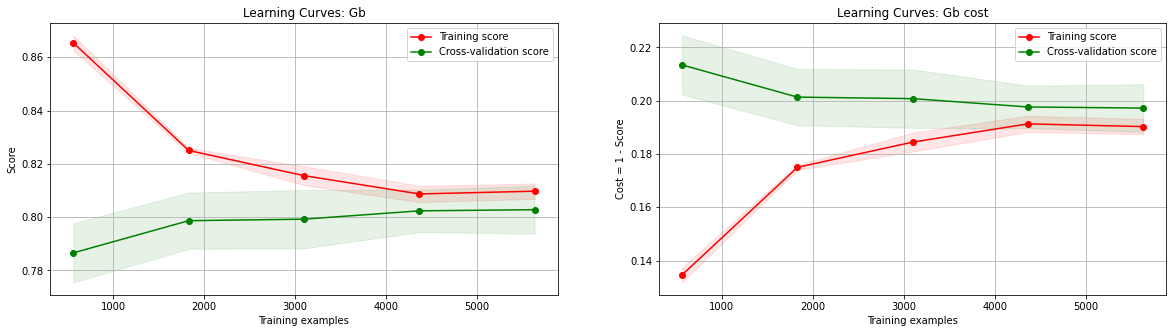

Evaluating all dataset with cross val predict






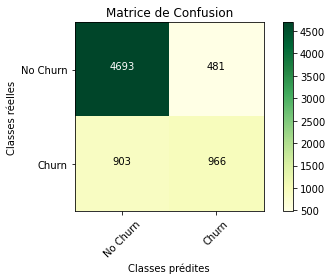

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = ('Gb',GradientBoostingClassifier(criterion='friedman_mse',
                           learning_rate=0.2, loss='deviance', max_depth=2,random_state=4))
gb_res = cross_val_monitor(clf_gb,X,y)

Compute the cross validation on : 7043 data split on 5 folds with Xgb estimator

 Display score: Xgb
Scores training f1 weighted : 0.802 (+/- 0.002)
Scores test f1 weighted : 0.795 (+/- 0.01)
Scores training accuracy : 0.81 (+/- 0.002)
Scores test accuracy : 0.803 (+/- 0.009)
Scores training roc_auc : 0.859 (+/- 0.003)
Scores test roc_auc : 0.844 (+/- 0.012)
Scores training precision : 0.682 (+/- 0.006)
Scores test precision : 0.666 (+/- 0.023)
Scores training recall : 0.531 (+/- 0.007)
Scores test recall : 0.521 (+/- 0.016)


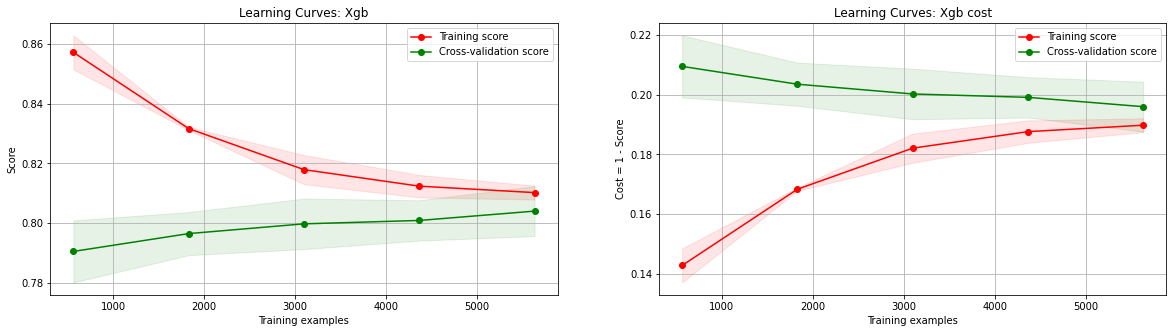

Evaluating all dataset with cross val predict






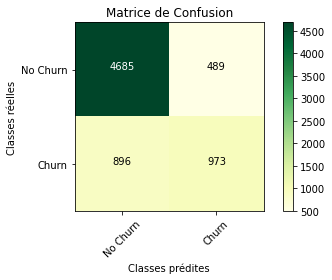

In [38]:
import xgboost as xgb
clf_xg = ('Xgb',xgb.XGBClassifier(base_score=0.5,gamma=0.5,
                                  learning_rate=0.1, max_depth=3,
                                  min_child_weight=5,n_estimators=100, n_jobs=1,
                                  objective='binary:logistic',random_state=19))
xg_res = cross_val_monitor(clf_xg,X,y)

Compute the cross validation on : 7043 data split on 5 folds with Ada estimator

 Display score: Ada
Scores training f1 weighted : 0.796 (+/- 0.003)
Scores test f1 weighted : 0.794 (+/- 0.009)
Scores training accuracy : 0.804 (+/- 0.003)
Scores test accuracy : 0.802 (+/- 0.009)
Scores training roc_auc : 0.846 (+/- 0.003)
Scores test roc_auc : 0.842 (+/- 0.011)
Scores training precision : 0.668 (+/- 0.007)
Scores test precision : 0.664 (+/- 0.024)
Scores training recall : 0.521 (+/- 0.01)
Scores test recall : 0.517 (+/- 0.015)


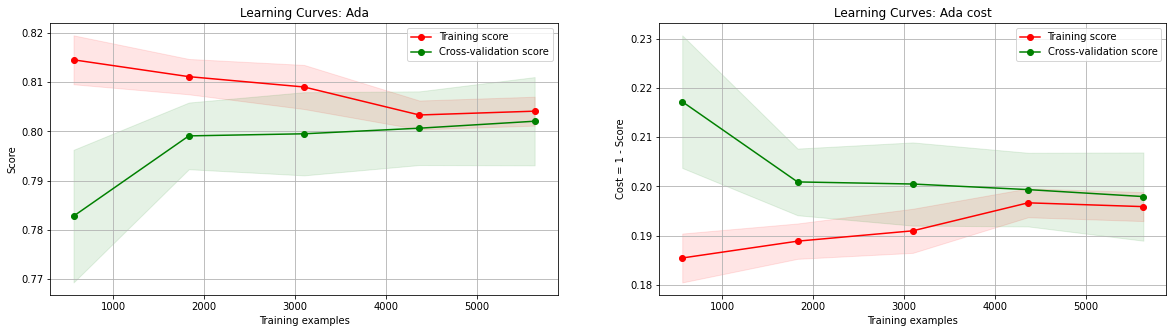

Evaluating all dataset with cross val predict






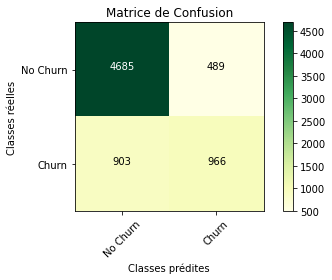

In [39]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada = ('Ada',AdaBoostClassifier(random_state=12))
ada_res = cross_val_monitor(clf_ada,X,y)

Compute the cross validation on : 7043 data split on 5 folds with CatB estimator

 Display score: CatB
Scores training f1 weighted : 0.809 (+/- 0.002)
Scores test f1 weighted : 0.794 (+/- 0.008)
Scores training accuracy : 0.817 (+/- 0.002)
Scores test accuracy : 0.803 (+/- 0.008)
Scores training roc_auc : 0.868 (+/- 0.003)
Scores test roc_auc : 0.839 (+/- 0.012)
Scores training precision : 0.699 (+/- 0.006)
Scores test precision : 0.667 (+/- 0.021)
Scores training recall : 0.546 (+/- 0.007)
Scores test recall : 0.517 (+/- 0.009)


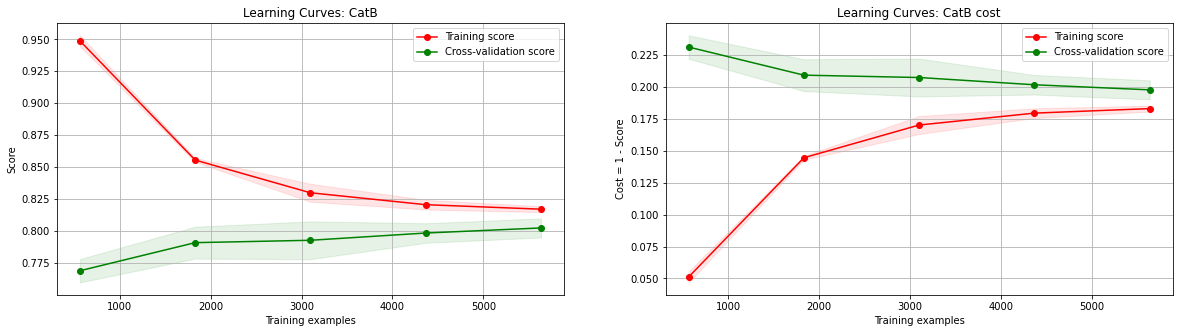

Evaluating all dataset with cross val predict






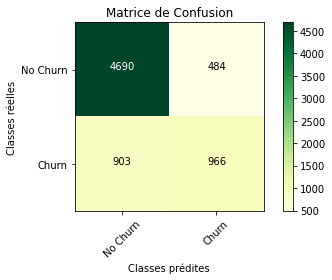

In [40]:
from catboost import CatBoostClassifier
clf_ct = ('CatB',CatBoostClassifier(depth = 3,l2_leaf_reg = 1e-20,
                                    loss_function = 'Logloss',random_state=5,logging_level='Silent'))
ct_res = cross_val_monitor(clf_ct,X,y)

### Model Performances

Our predictions models results are very close

In [41]:
cm = sns.light_palette("green", as_cmap=True)
df_res = pd.concat([lr_res,Dt_res,knn_res,rf_res,svm_score,sgd_res,gb_res,xg_res,ada_res,ct_res],axis=0).reset_index(drop=True)
df_res = df_res.sort_values(by='test_f1_weighted',ascending=False)
s = df_res.style.background_gradient(cmap=cm)
s

### Plotting performances measures

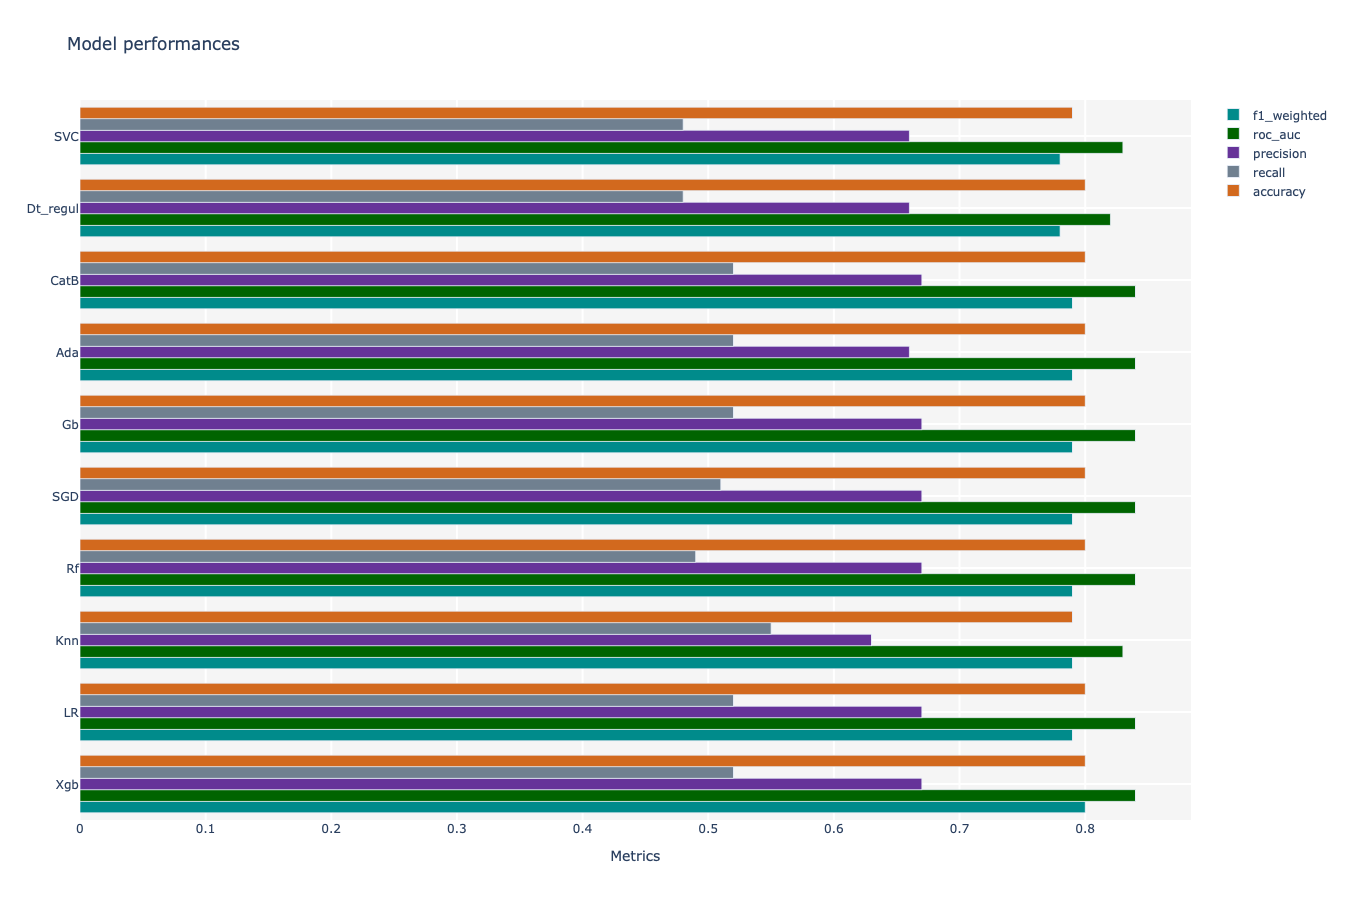

In [42]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
#initate plotly
pyoff.init_notebook_mode()

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor = "whitesmoke",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metrics",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 900
                       )
                  )


f1_score_w  = plot_performances(df_res,'Model_name',"test_f1_weighted","darkcyan")
roc_auc_s  = plot_performances(df_res,'Model_name','test_roc_auc',"darkgreen")
precision_s  = plot_performances(df_res,'Model_name','test_precision',"rebeccapurple")
recall_s  = plot_performances(df_res,'Model_name','test_recall',"slategray")
accuracy_s  = plot_performances(df_res,'Model_name','test_accuracy',"chocolate")
data = [f1_score_w,roc_auc_s,precision_s,recall_s,accuracy_s]
fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

Test our best_models based on f1_weighted score and recall </br> 
Because it's the metrics we have to optimize in this business

In [43]:
#Train test split 
#80% train 20% test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y)

In [44]:
X_test.shape

(1409, 32)

Let's run each best_models and see some results reports.
Here the best model based on the f1-score is LR but it's very close to the others models


LR


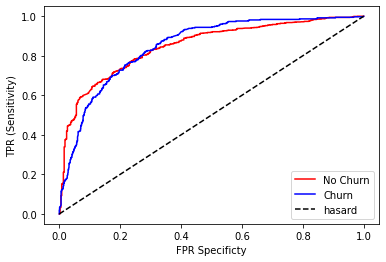

Matrice de confusion :



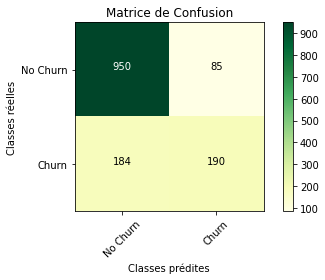

Resultats :

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1035
           1       0.69      0.51      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409


Xgb


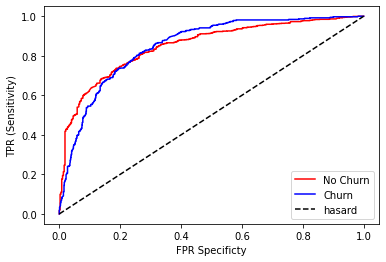

Matrice de confusion :



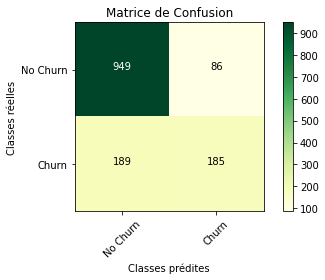

Resultats :

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


Ada


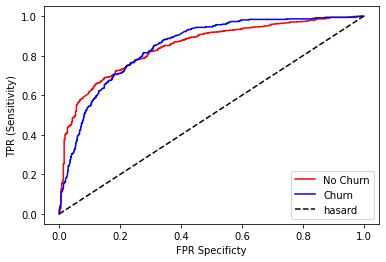

Matrice de confusion :



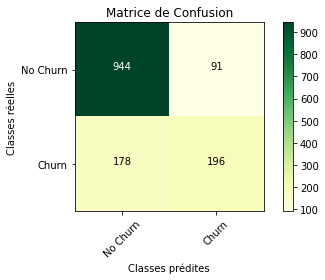

Resultats :

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


Gb


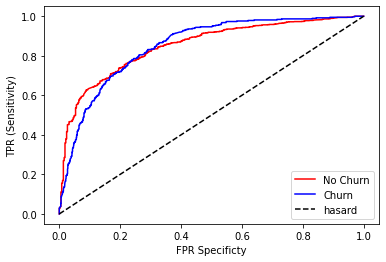

Matrice de confusion :



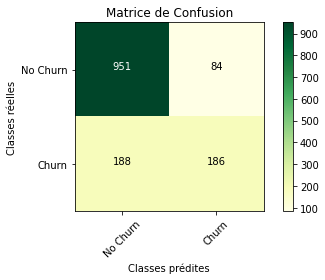

Resultats :

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.69      0.50      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409


SGD
L'estimator n'a pas de probabilités

Matrice de confusion :



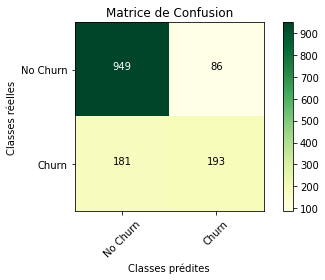

Resultats :

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1035
           1       0.69      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



'le meilleure modèle est : SGD avec un f1-score de : 0.8008772666709808'

In [45]:
First_clf =  [Lr_tuple,clf_xg,clf_ada,clf_gb,clf_sgd]

compute_performances(First_clf,
            X_train,
            y_train,
            X_test,
            y_test)

Feature Importance

<Figure size 720x720 with 0 Axes>

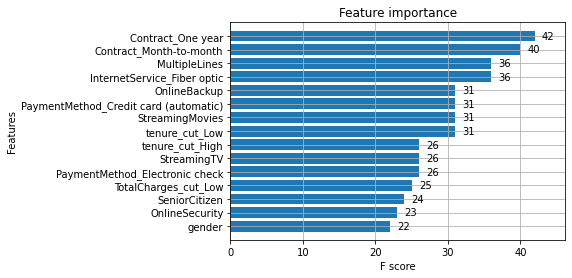

In [55]:
plt.figure(figsize=(10,10))
model_xg = clf_xg[1].fit(X_train,y_train)
xgb.plot_importance(model_xg, max_num_features=15, height=0.8)
plt.show()

### Let's explore the predictions (More to come)

In [56]:
Lst_clf = [Lr_tuple,clf_sgd,clf_ada,clf_gb,clf_knn,rf_regul,clf_tree_regul,clf_xg,clf_ct]
pred_df = construct_df_pred(Lst_clf,X_train,y_train,X_test)

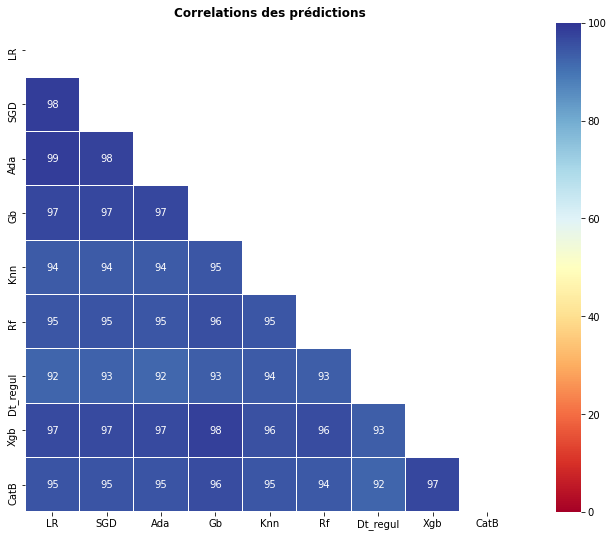

In [61]:
#This matrix compute the difference between each predictions model
#In goal to see how much our models differs from each others 
#But we can see that the results are very similar
#This heatmap allow us to see that ours model are very correlated
construct_corr_matrix(pred_df,colormap=plt.cm.RdYlBu)

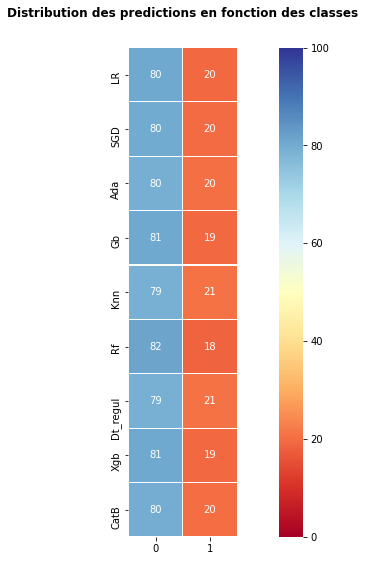

In [62]:
distribution_class(pred_df,colormap=plt.cm.RdYlBu)

In [63]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

Compute the cross validation on : 7043 data split on 5 folds with soft estimator

 Display score: soft
Scores training f1 weighted : 0.8 (+/- 0.003)
Scores test f1 weighted : 0.795 (+/- 0.009)
Scores training accuracy : 0.808 (+/- 0.002)
Scores test accuracy : 0.804 (+/- 0.009)
Scores training roc_auc : 0.854 (+/- 0.003)
Scores test roc_auc : 0.844 (+/- 0.011)
Scores training precision : 0.679 (+/- 0.006)
Scores test precision : 0.668 (+/- 0.022)
Scores training recall : 0.526 (+/- 0.009)
Scores test recall : 0.517 (+/- 0.019)


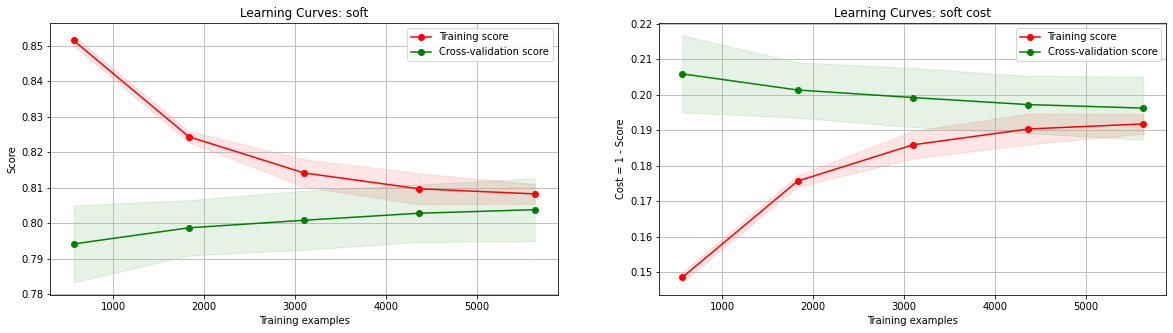

Evaluating all dataset with cross val predict






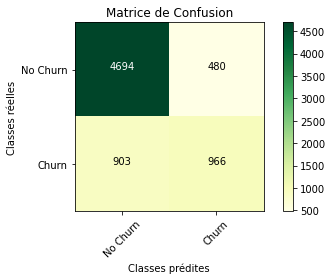

In [64]:
eclf1 = VotingClassifier(estimators=[Lr_tuple,clf_xg,clf_gb], voting='soft')
clf_ens1 = ('soft',eclf1)
clf_ens1_res = cross_val_monitor(clf_ens1,X,y)


soft


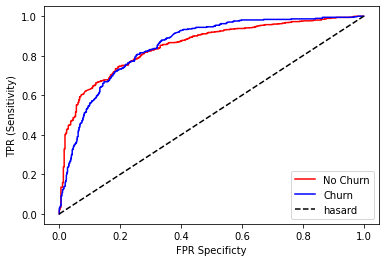

Matrice de confusion :



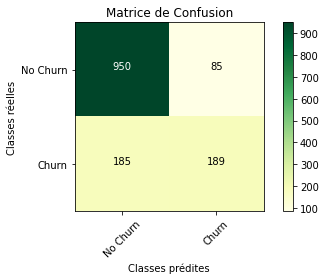

Resultats :

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1035
           1       0.69      0.51      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



'le meilleure modèle est : soft avec un f1-score de : 0.7980041624012412'

In [65]:
#Exemple running
#Liste de modèle 
First_clf =  [clf_ens1]

compute_performances(First_clf,
            X_train,
            y_train,
            X_test,
            y_test)

In [66]:
eclf2 = VotingClassifier(estimators=[Lr_tuple,clf_ada,clf_sgd,clf_gb,clf_xg,clf_knn], voting='hard')
clf_ens2 = ('soft',eclf2)
clf_ens2_res = cross_val_score(eclf2,X,y,cv=5,scoring='f1_weighted')

In [67]:
np.mean(clf_ens2_res)

0.7950017203403625